In [1]:
import os
import sys
import random
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import json
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from scipy.stats import spearmanr, pearsonr
import argparse
from scipy.stats import norm
import numpy as np
from collections import Counter
import seaborn as sns 
import matplotlib.pyplot as plt
# import matplolib.pyplot as plt

In [2]:
device = torch.device("cuda")
print(f"Using device: {device}", flush=True)

Using device: cuda


In [201]:
import torch.nn.init as init

import torch
import torch.nn as nn
import torch.nn.init as init

class ESMBA(nn.Module):
    def __init__(self, base_model, dropout=0.3):
        """
        Args:
            base_model: A pretrained model that returns a structure with a
                        'hidden_states' attribute (last_hidden_state).
            dropout (float): Dropout rate applied after pooling.
        """
        super(ESMBA, self).__init__()
        self.base_model = base_model
        self.dropout = nn.Dropout(dropout)
        self.regression_head = nn.Linear(960, 1)

        init.xavier_uniform_(self.regression_head.weight, gain=0.01)
        nn.init.uniform_(self.regression_head.bias, a=0.0, b=1.0)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.base_model.forward(input_ids)
        hidden_states = outputs.hidden_states[-1].to(torch.float32)

        mask = attention_mask.unsqueeze(-1).float()
        masked_hidden_states = hidden_states * mask
        sum_embeddings = masked_hidden_states.sum(dim=1)
        sum_mask = mask.sum(dim=1)

        pooled_output = sum_embeddings / (sum_mask + 1e-8)
        pooled_output = self.dropout(pooled_output)
        regression_output = self.regression_head(pooled_output).squeeze(-1)
        return regression_output

    def get_intermediate(self, input_ids, attention_mask=None):
        """
        Returns the same pooled output used for regression head input
        (size = 960).
        """
        outputs = self.base_model.forward(input_ids)
        hidden_states = outputs.hidden_states[-1].to(torch.float32)
    
        mask = attention_mask.unsqueeze(-1).float()
        masked_hidden_states = hidden_states * mask
        sum_embeddings = masked_hidden_states.sum(dim=1)
        sum_mask = mask.sum(dim=1)
    
        pooled_output = sum_embeddings / (sum_mask + 1e-8)
        return pooled_output  # changed from returning hidden_states

def load_model(model_path, device="cuda"):
    checkpoint = torch.load(model_path, map_location=device)

    # If needed, ensure you set output_hidden_states=True in from_pretrained or config
    base_model = ESMC.from_pretrained("esmc_300m")  
    base_model.to(device)

    model = ESMBA(base_model=base_model, dropout=0.3)
    model.to(device)

    # If checkpoint has unexpected keys:
    state_dict = checkpoint #["model_state_dict"]
    # e.g. remove old heads
    state_dict = {
        k: v for k, v in state_dict.items() 
        if not k.startswith("mask_head")
    }

    # (if you used DDP => strip 'module.')
    # new_state_dict = {}
    # for k, v in state_dict.items():
    #     new_state_dict[k.replace('module.', '')] = v
    # # state_dict = new_state_dict

    model.load_state_dict(state_dict, strict=False)
    return model

if __name__ == "__main__":
    device = "cuda" if torch.cuda.is_available() else "cpu"
    file_path = "/global/scratch/users/sergiomar10/models/ESMCBA/HLAA0101/training_ESMCBA_epitope_0.95_30_True-Full_pretraining_30000_seq_AUG_3_ALL_HLAS_0.0001_1e-06__3_A0101_final.pth"

    # 3. Actually load the model
    model = load_model(model_path=file_path, device=device)

    # 4. You can now use model in inference
    base_model = model.base_model  # if you need direct access
    print("Model loaded successfully!")

Model loaded successfully!


In [202]:
################################################
# Sparse Autoencoder (Extended)
################################################
class DeepSparseAutoencoder(nn.Module):
    """
    A deeper sparse autoencoder with optional BatchNorm and dropout
    to capture more complex relationships.
    """
    def __init__(self, input_dim=960, hidden_dims=(512, 128), dropout=0.1):
        """
        Args:
            input_dim (int): Size of the ESM embedding (960).
            hidden_dims (tuple): Sizes of intermediate layers, e.g. (512, 128).
            dropout (float): Dropout probability.
        """
        super(DeepSparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.BatchNorm1d(hidden_dims[1]),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dims[1], hidden_dims[0]),
            nn.BatchNorm1d(hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dims[0], input_dim),
            # no activation or a sigmoid?
            # If your original input is unbounded or around normal scale, 
            # often no final activation is used for reconstruction.
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

def l1_penalty(activation, alpha=1e-3):
    """
    Compute an L1 penalty on the activation (z) to induce sparsity.
    alpha is a hyperparameter controlling the penalty strength.
    """
    return alpha * torch.mean(torch.abs(activation))

def train_sae(
    sae, 
    train_embeddings, 
    val_embeddings=None,
    epochs=5, 
    lr=1e-3, 
    alpha=1e-3,
    batch_size=64,
    device="cuda"
):
    """
    Train the autoencoder on train_embeddings and optionally evaluate 
    on val_embeddings each epoch.
    """
    sae = sae.to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=lr)
    mse_loss = nn.MSELoss()

    # Turn embeddings into a dataset
    train_dataset = torch.utils.data.TensorDataset(train_embeddings)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    if val_embeddings is not None:
        val_dataset = torch.utils.data.TensorDataset(val_embeddings)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    else:
        val_loader = None

    for epoch in range(epochs):
        sae.train()
        total_loss, total_samples = 0.0, 0

        for batch in train_loader:
            x = batch[0].to(device)

            optimizer.zero_grad()
            x_hat, z = sae(x)
            loss_recon = mse_loss(x_hat, x)
            loss_sparsity = l1_penalty(z, alpha)
            loss = loss_recon + loss_sparsity
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(x)
            total_samples += len(x)

        avg_train_loss = total_loss / total_samples

        # Evaluate on validation set if provided
        if val_loader is not None:
            sae.eval()
            val_loss, val_samples = 0.0, 0
            with torch.no_grad():
                for batch in val_loader:
                    x_val = batch[0].to(device)
                    x_hat_val, z_val = sae(x_val)
                    loss_val_recon = mse_loss(x_hat_val, x_val)
                    loss_val_sparsity = l1_penalty(z_val, alpha)
                    loss_val = loss_val_recon + loss_val_sparsity

                    val_loss += loss_val.item() * len(x_val)
                    val_samples += len(x_val)
            avg_val_loss = val_loss / val_samples

            print(f"Epoch [{epoch+1}/{epochs}] "
                  f"Train Loss: {avg_train_loss:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}")
        else:
            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}")

    return sae

################################################
# Utilities to collect embeddings
################################################
def collect_intermediate_embeddings(model, data_loader, device="cuda"):
    """
    model: your fine-tuned ESMBA instance
    data_loader: yields (sequences, protein_tensors, targets)
    Returns a single torch.Tensor of shape (N, 960) containing 
    all pooled embeddings from the dataset.
    """
    model.eval()
    all_embeddings = []

    with torch.no_grad():
        for sequences, _, _ in data_loader:
            encoded_seq = model.base_model.tokenizer(
                sequences, 
                return_tensors='pt', 
                padding=True,
                max_length=15,
                truncation=True    
            )
            input_ids = encoded_seq.input_ids.to(device)
            attention_mask = encoded_seq.attention_mask.to(device)

            # Extract 960-dim representation:
            batch_embeddings = model.get_intermediate(input_ids, attention_mask)
            # store on CPU:
            all_embeddings.append(batch_embeddings)

    # Concatenate everything into [N, 960]
    return all_embeddings

In [226]:
from scipy.stats import norm
encoding = 'epitope'

################################################
# 6. Define a simple FASTA parser
################################################
def parse_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as f:
        header = None
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append((header, seq))
                    seq = ""
                header = line[1:]
            else:
                seq += line
        # Append the last sequence if present
        if seq:
            sequences.append((header, seq))
    return sequences

train_fasta = f"/global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_HLA{'A0101'}_final.csv"

epitope_data = pd.read_csv(train_fasta, header = None)
epitope_data.columns = ['sequence', 'ref_ID', 'submissionID', 'Epitope_ID','protein_origin', 'ID_SOURCE', "SOURCE_ORGANISM", "IC50_nM", "DESCRIPTION_BINDING", "Year_submission"]
HLA_0201 = "MIQRTPKIQVYSRHPAENGKSNFLNCYVSGFHPSDIEVDLLKNGERIEKVEHSDLSFSKDWSFYLLYYTEFTPTEKDEYACRVNHVTLSQPKIVKWDRDMGSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRMEPRAPWIEQEGPEYWDGETRKVKAHSQTHRVDLGTLRGYYNQSEAGSHTVQRMYGCDVGSDWRFLRGYHQYAYDGKDYIALKEDLRSWTAADMAAQTTKHKWEAAHVAEQLRAYLEGTCVEWLRRYLENGKETLQRTDAPKTHMTHHAVSDHEATLRCWALSFYPAEITLTWQRDGEDQTQDTELVETRPAGDGTFQKWAAVVVPSGQEQRYTCHVQHEGLPKPLTLRWEP"

epitope_data['IC50_nM'] = epitope_data['IC50_nM'].astype(str)
epitope_data['IC50_nM'] = epitope_data['IC50_nM'].str.replace('\\N', '0', regex=False)
epitope_data['IC50_nM'] = epitope_data['IC50_nM'].astype('float')
epitope_data['IC50_nM'] = epitope_data['IC50_nM'] + 1
epitope_data['IC50_nM'] = epitope_data['IC50_nM'].apply(np.log10)

epitope_data['Year_submission'] = epitope_data['Year_submission'].astype(str)
epitope_data['Year_submission'] = epitope_data['Year_submission'].str.replace('\\N', '0', regex=False)
epitope_data['Year_submission'] = epitope_data['Year_submission'].astype(int)

epitope_data = epitope_data[["IC50_nM","sequence","Year_submission"]]

epitope_data = epitope_data.values

filtered_data = []

for header, sequence, year_submission in epitope_data:
    if '+' in sequence:
        continue
    if '(' in sequence:
        continue
    if 'X' in sequence:
        continue
    if 'epitope' not in encoding:   
        sequence = HLA_0201 + sequence
        
    filtered_data.append((header, sequence, year_submission))

print(f"Filtered {len(filtered_data)} sequences for training.", flush=True)

aggregated = pd.DataFrame(filtered_data, columns = ['label','sequence','testing'])
# aggregated = aggregated.iloc[:100]

def split_data(aggregated, size_of_train=1.0):
    """
    Split data into Train (bin-sampled), Validation (10% of that train),
    and Test (20% of total). For final 'external' test, you can still use
    aggregated['Year_submission'] > 2020 if desired.
    """
    # 1) Split out the portion to treat as test_data (20%)
    #    from the portion <= 2020
    training_data = aggregated[aggregated['testing'] <= 2020]

    # 2) Bin-sample 'train_data' according to your normal approach
    print(f'Threshold used for generating the training data {size_of_train}', flush=True)
    bin_edges = [0, 1, 2, 3, 4, 5, 6, 7]
    bin_centers_normal = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
    pmf = norm.pdf(bin_centers_normal, loc=3, scale=1.0)
    pmf /= pmf.sum()
    total_samples = int(size_of_train * len(training_data))
    bin_samples_normal = np.round(pmf * total_samples).astype(int)

    sampled_sequences, sampled_labels = [], []
    for i in range(len(bin_centers_normal)):
        bin_min = bin_edges[i]
        bin_max = bin_edges[i + 1]
        df_bin = training_data[(training_data["label"] > bin_min) & (training_data["label"] <= bin_max)]
        n_samples = min(bin_samples_normal[i], len(df_bin))
        if n_samples > 0:
            sample = df_bin.sample(n=n_samples)
            sampled_sequences.extend(sample["sequence"].tolist())
            sampled_labels.extend(sample["label"].tolist())

    # Construct the final "train_data" from the bin-sampled sequences
    final_train = pd.DataFrame({"sequence": sampled_sequences, "label": sampled_labels})

    # 3) Now split *final_train* into 90% train, 10% validation
    #    This ensures we keep 10% (of the final training set) for validation
    train_data_final, val_data_final = train_test_split(
        final_train, 
        test_size=0.1,
        shuffle=True
    )

    # Optional histogram to check distribution
    num_bins = 7
    counts, bin_edges_ = np.histogram(train_data_final['label'], bins=num_bins)
    max_count = max(counts) if len(counts) > 0 else 1
    scale_factor = 50 / max_count

    print(f"\nTrain Histogram with {num_bins} Bins (after bin-sampling & removing val set):")
    for i in range(len(bin_edges_) - 1):
        bin_range = f"[{bin_edges_[i]:.2f}, {bin_edges_[i+1]:.2f})"
        bar = "#" * int(counts[i] * scale_factor)
        print(f"{bin_range}: {bar} ({counts[i]})")

    print('We are generating the 2021 Testing set', flush = True)

    test_data = aggregated[aggregated['testing'] > 2020]

    if len(test_data['label']) < 10:
        print('Not enough samples past the 2021 treshold', flush = True)
        output_table = aggregated[~aggregated["sequence"].isin(sampled_sequences)]
        test_data = pd.concat([output_table, test_data])

    test_data = test_data[['sequence','label']]

    return train_data_final, val_data_final, test_data

from torch.utils.data import Dataset, DataLoader
import torch

# Your dataset now computes the protein object (and encoding) during __getitem__
class EpitopeDataset(Dataset):
    def __init__(self, sequences, labels, base_model=base_model, precompute=False):
        self.labels = labels
        if precompute:
            # Precompute the protein objects (and their encodings) once and store them
            self.data = []
            for seq in sequences:
                protein_obj = ESMProtein(sequence=seq)
                # Precompute the encoding (if your base_model is frozen or you want to save time)
                protein_tensor = base_model.encode(protein_obj)
                self.data.append((protein_obj, protein_tensor))
        else:
            # Otherwise, store the raw sequences so that they are computed on the fly in __getitem__
            self.sequences = sequences

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        if hasattr(self, "data"):
            # If precomputed, return the stored protein object and its encoding.
            protein_obj, protein_tensor = self.data[idx]
            return protein_obj, protein_tensor, torch.tensor(label, dtype=torch.float)
        else:
            # Otherwise, compute the protein object (and encoding) on the fly.
            seq = self.sequences[idx]
            protein_obj = ESMProtein(sequence=seq)
            protein_tensor = base_model.encode(protein_obj)
            return seq, protein_tensor, torch.tensor(label, dtype=torch.float)

# A collate function that gathers protein objects into a list (they may have varying shapes)
def collate_fn(batch):
    # Each element of batch is (sequence, protein_tensor, label)
    sequences, protein_tensors, labels = zip(*batch)
    # Leave sequences as a list (they are custom objects)
    # If protein_tensors have the same shape you can stack them, otherwise leave as list:
    try:
        protein_tensors = torch.stack(protein_tensors)
    except Exception:
        protein_tensors = list(protein_tensors)
    labels = torch.stack(labels)
    return list(sequences), protein_tensors, labels

# Data preparation function
def prepare_dataloaders(dataframe, batch_size=10, size_of_train=1):
    """
    Split the dataframe into train, validation, and test sets,
    then return corresponding DataLoader objects.
    """
    print(f"\n----------------------------------------\nPreparing data...", flush=True)
    
    train_data, val_data, test_data = split_data(dataframe, size_of_train=size_of_train)
    
    # train_data = pd.concat([train_data.sort_values(by='label')[:500], train_data.sort_values(by='label')[-500:]])
    
    print(f"Training samples: {len(train_data)}, "
          f"Validation samples: {len(val_data)}, "
          f"Test samples: {len(test_data)}\n----------------------------------------\n", flush=True)

    train_dataset = EpitopeDataset(
        sequences=train_data["sequence"].values,
        labels=train_data["label"].values,
    )
    val_dataset = EpitopeDataset(
        sequences=val_data["sequence"].values,
        labels=val_data["label"].values,
    )
    test_dataset = EpitopeDataset(
        sequences=test_data["sequence"].values,
        labels=test_data["label"].values,
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    return train_loader, val_loader, test_loader, train_data, val_data, test_data

size_of_train = 1

# Prepare the DataLoaders (no tokenization in the DataLoader)
train_loader, val_loader, test_loader, train_data, val_data, test_data = prepare_dataloaders(
    dataframe=aggregated,
    batch_size=10,
    size_of_train=size_of_train
)

criterion = nn.MSELoss()

Filtered 3925 sequences for training.

----------------------------------------
Preparing data...
Threshold used for generating the training data 1

Train Histogram with 7 Bins (after bin-sampling & removing val set):
[0.15, 0.98): #### (59)
[0.98, 1.82): ################# (228)
[1.82, 2.66): ###################### (301)
[2.66, 3.49): ############################ (376)
[3.49, 4.33): ################################################## (658)
[4.33, 5.17): ######### (127)
[5.17, 6.00): # (19)
We are generating the 2021 Testing set
Training samples: 1768, Validation samples: 197, Test samples: 98
----------------------------------------



In [227]:
model.eval()
train_embeddings = collect_intermediate_embeddings(model, train_loader, device)
val_embeddings = collect_intermediate_embeddings(model, val_loader, device) if len(val_data) > 0 else None

In [228]:
train_embeddings = torch.cat(train_embeddings, dim = 0)
val_embeddings = torch.cat(val_embeddings, dim = 0)

In [229]:
print(f"train_embeddings shape = {train_embeddings_done.shape}")
# if val_embeddings is not None:
#     print(f"val_embeddings shape = {val_embeddings.shape}")

train_embeddings shape = torch.Size([345, 960])


In [253]:
# 5. Build and train a deeper Sparse Autoencoder
sae = DeepSparseAutoencoder(input_dim=960, hidden_dims=(200, 100), dropout=0.1)
sae = train_sae(
    sae,
    train_embeddings=train_embeddings_done,
    val_embeddings=val_embeddings,
    epochs=10,       # more epochs for deeper net
    lr=1e-1,
    alpha=1e-1,
    batch_size=64,
    device=device
)

Epoch [1/10] Train Loss: 3386.6825 | Val Loss: 11824.2474
Epoch [2/10] Train Loss: 2896.2048 | Val Loss: 2941.9923
Epoch [3/10] Train Loss: 2139.8400 | Val Loss: 1514.8526
Epoch [4/10] Train Loss: 1151.8562 | Val Loss: 745.2056
Epoch [5/10] Train Loss: 506.7015 | Val Loss: 478.6503
Epoch [6/10] Train Loss: 312.4806 | Val Loss: 339.3373
Epoch [7/10] Train Loss: 278.6669 | Val Loss: 272.4579
Epoch [8/10] Train Loss: 239.8585 | Val Loss: 219.7033
Epoch [9/10] Train Loss: 204.2116 | Val Loss: 184.8768
Epoch [10/10] Train Loss: 179.9689 | Val Loss: 177.7011


Encoder layer #1 weight matrix shape: (200, 960)


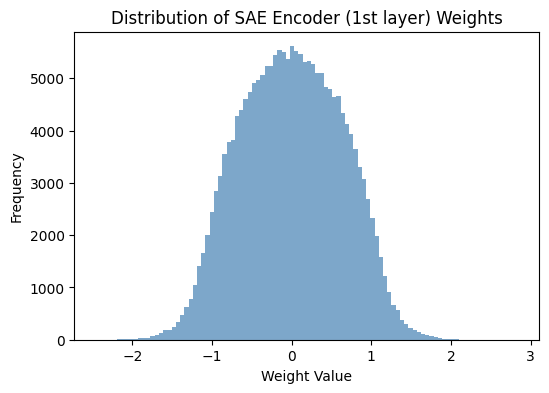

Final training MSE reconstruction error: 179.2263
Latent dimension shape: (1768, 100)


In [254]:
# 6. Analyze learned SAE
# ------------------------
# a) Visualize encoder weights
encoder_layers = sae.encoder[0].weight.data.cpu().numpy()  # The first layer weight => shape [512, 960]
print("Encoder layer #1 weight matrix shape:", encoder_layers.shape)

# b) Check distribution of first-layer weights
flat_weights = encoder_layers.flatten()
plt.figure(figsize=(6,4))
plt.hist(flat_weights, bins=100, alpha=0.7, color="steelblue")
plt.title("Distribution of SAE Encoder (1st layer) Weights")
plt.xlabel("Weight Value")
plt.ylabel("Frequency")
plt.show()

# c) Evaluate reconstruction on train set
sae.eval()
with torch.no_grad():
    x_hat, z = sae(train_embeddings.to(device))
    train_mse = F.mse_loss(x_hat, train_embeddings.to(device)).item()
print(f"Final training MSE reconstruction error: {train_mse:.4f}")

# d) Check latent dimension shape
z = z.cpu().numpy()  # shape [N, 128]
print("Latent dimension shape:", z.shape)

# e) Visualize latent space with t-SNE (can be slow if N is large)
#    For motif or cluster detection, a t-SNE or UMAP might give clues.
if z.shape[0] > 3000:
    # You can sample to speed up
    idxs = np.random.choice(z.shape[0], size=3000, replace=False)
    z_sample = z[idxs]
else:
    z_sample = z

/clusterfs/nilah/sergio/miniconda3/envs/ESM_cambrian/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1768 samples in 0.000s...
[t-SNE] Computed neighbors for 1768 samples in 0.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1768
[t-SNE] Computed conditional probabilities for sample 1768 / 1768
[t-SNE] Mean sigma: 2.188666
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.298141
[t-SNE] KL divergence after 1000 iterations: 1.088449


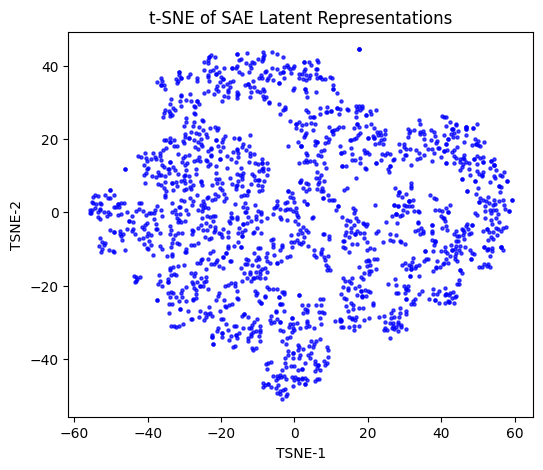


Top 10 neurons with highest fraction of near-zero activation:
[58 32 43  6 26 54 10 12 86 34]

Top 5 latent dims (by absolute correlation with label):
  Dim 6 => Corr: nan
  Dim 17 => Corr: -0.042
  Dim 20 => Corr: -0.036
  Dim 1 => Corr: -0.031
  Dim 9 => Corr: 0.030

Done! Sparse Autoencoder training and analysis completed.


/tmp/ipykernel_423088/3485928972.py:24: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(z[:, i], train_labels)


In [255]:

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
z_tsne = tsne.fit_transform(z_sample)

plt.figure(figsize=(6,5))
plt.scatter(z_tsne[:,0], z_tsne[:,1], s=5, alpha=0.7, c='blue')
plt.title("t-SNE of SAE Latent Representations")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.show()

# f) If you want to see which latent neurons are "most sparse":
frac_zero = np.mean(np.isclose(z, 0.0, atol=1e-3), axis=0)
top_sparse_neurons = np.argsort(-frac_zero)
print("\nTop 10 neurons with highest fraction of near-zero activation:")
print(top_sparse_neurons[:10])

# g) If you want to see if any latent dimension correlates with label:
#    Re-attach the train labels
train_labels = train_data["label"].values
if z.shape[0] == len(train_labels):
    corr_vals = []
    for i in range(z.shape[1]):
        r, _ = pearsonr(z[:, i], train_labels)
        corr_vals.append((i, r))
    corr_vals.sort(key=lambda x: abs(x[1]), reverse=True)
    print("\nTop 5 latent dims (by absolute correlation with label):")
    for dim_idx, corr_val in corr_vals[:5]:
        print(f"  Dim {dim_idx} => Corr: {corr_val:.3f}")

print("\nDone! Sparse Autoencoder training and analysis completed.")

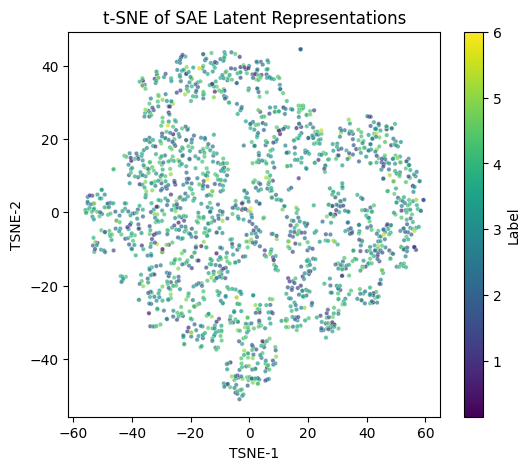

In [256]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure labels are floats
labels = train_data['label'].astype(float).values

# Create figure and axis
fig, ax = plt.subplots(figsize=(6,5))

# Use seaborn's scatterplot on the specified axis, but disable its legend
sns.scatterplot(
    x=z_tsne[:, 0],
    y=z_tsne[:, 1],
    hue=labels,
    palette="viridis",
    s=10,
    alpha=0.7,
    legend=False,
    ax=ax
)

ax.set_title("t-SNE of SAE Latent Representations")
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")

# Create a ScalarMappable for the colorbar using the same colormap and normalization
norm = plt.Normalize(labels.min(), labels.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # This line ensures compatibility with older versions of matplotlib

# Add the colorbar to the axis
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Label")

plt.show()


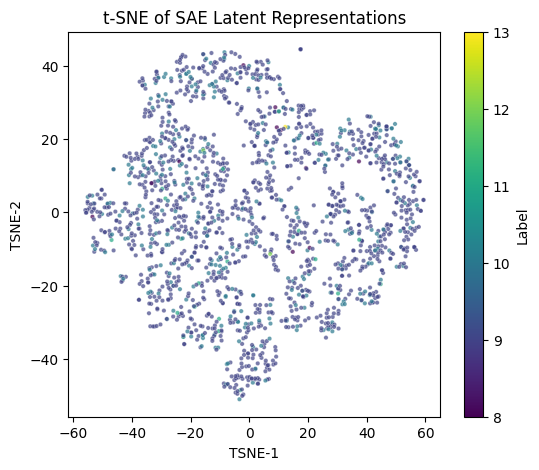

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure labels are floats
labels = train_data['sequence'].apply(len).values

# Create figure and axis
fig, ax = plt.subplots(figsize=(6,5))

# Use seaborn's scatterplot on the specified axis, but disable its legend
sns.scatterplot(
    x=z_tsne[:, 0],
    y=z_tsne[:, 1],
    hue=labels,
    palette="viridis",
    s=10,
    alpha=0.7,
    legend=False,
    ax=ax
)

ax.set_title("t-SNE of SAE Latent Representations")
ax.set_xlabel("TSNE-1")
ax.set_ylabel("TSNE-2")

# Create a ScalarMappable for the colorbar using the same colormap and normalization
norm = plt.Normalize(labels.min(), labels.max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])  # This line ensures compatibility with older versions of matplotlib

# Add the colorbar to the axis
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Label")

plt.show()


/tmp/ipykernel_423088/1403735485.py:6: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, _ = pearsonr(z[:, i], train_labels)


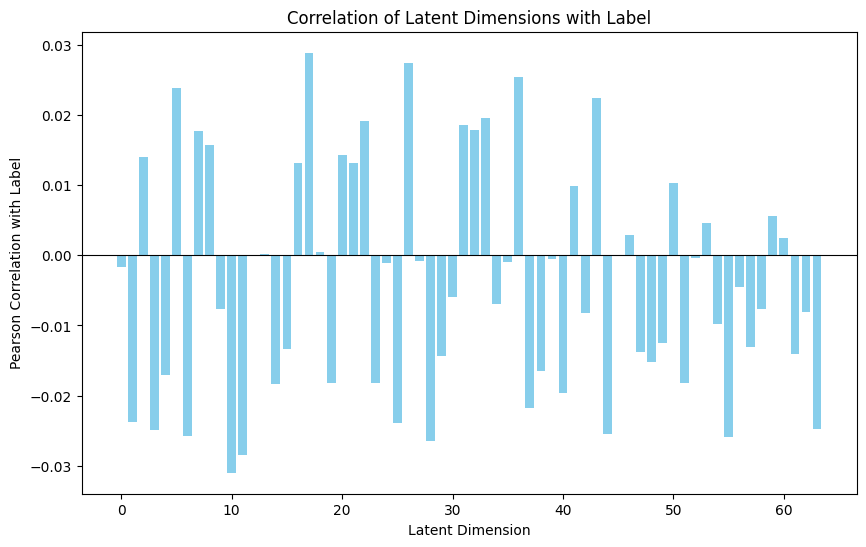


Top 5 latent dims (by absolute correlation with label):
  Dim 45 => Corr: nan
  Dim 12 => Corr: nan
  Dim 10 => Corr: -0.031
  Dim 17 => Corr: 0.029
  Dim 11 => Corr: -0.029


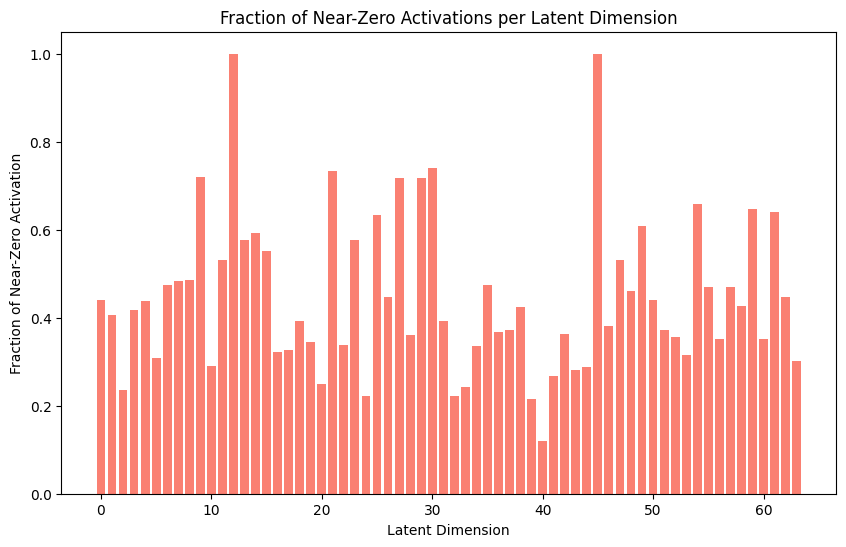


Top 10 neurons with highest fraction of near-zero activation:
[12 45 30 21  9 29 27 54 59 61]


In [234]:
train_labels = train_data["label"].astype(float).values

# --- Compute Pearson correlations for each latent dimension ---
corr_vals = []
for i in range(z.shape[1]):
    r, _ = pearsonr(z[:, i], train_labels)
    corr_vals.append(r)
corr_vals = np.array(corr_vals)

# Plot correlations across latent dimensions
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(corr_vals)), corr_vals, color='skyblue')
plt.xlabel("Latent Dimension")
plt.ylabel("Pearson Correlation with Label")
plt.title("Correlation of Latent Dimensions with Label")
plt.axhline(0, color='black', linewidth=0.8)
plt.show()

# Identify and print the top 5 latent dimensions (by absolute correlation)
top5_dims = np.argsort(np.abs(corr_vals))[-5:][::-1]
print("\nTop 5 latent dims (by absolute correlation with label):")
for i in top5_dims:
    print(f"  Dim {i} => Corr: {corr_vals[i]:.3f}")

# --- Compute fraction of near-zero activation for each latent dimension ---
frac_zero = np.mean(np.isclose(z, 0.0, atol=1e-3), axis=0)

# Plot fraction of near-zero activations per latent dimension
plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(frac_zero)), frac_zero, color='salmon')
plt.xlabel("Latent Dimension")
plt.ylabel("Fraction of Near-Zero Activation")
plt.title("Fraction of Near-Zero Activations per Latent Dimension")
plt.show()

# Identify and print the top 10 neurons with highest fraction of near-zero activation
top10_neurons = np.argsort(-frac_zero)[:10]
print("\nTop 10 neurons with highest fraction of near-zero activation:")
print(top10_neurons)


/tmp/ipykernel_423088/2507760955.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(latent_variances)), y=latent_variances, palette="viridis")


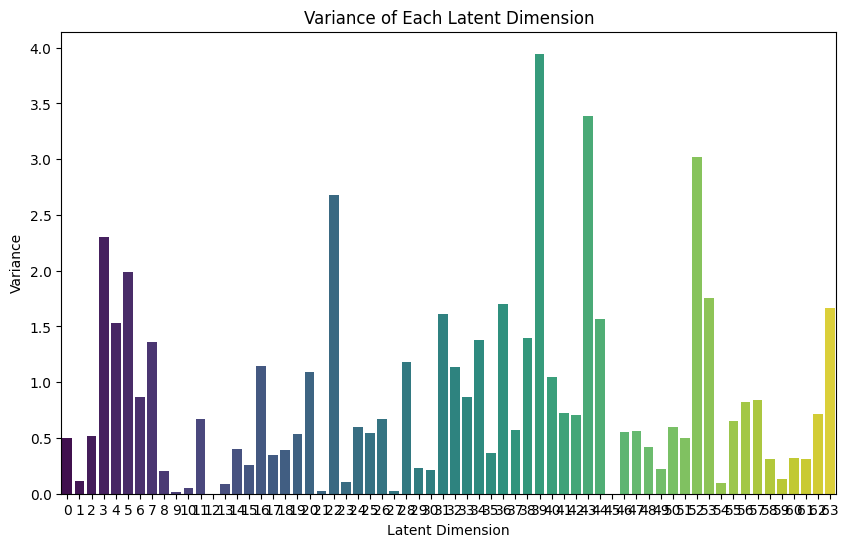

Number of near-zero variance latent dimensions: 2


/tmp/ipykernel_423088/2507760955.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(mi_scores)), y=mi_scores, palette="viridis")


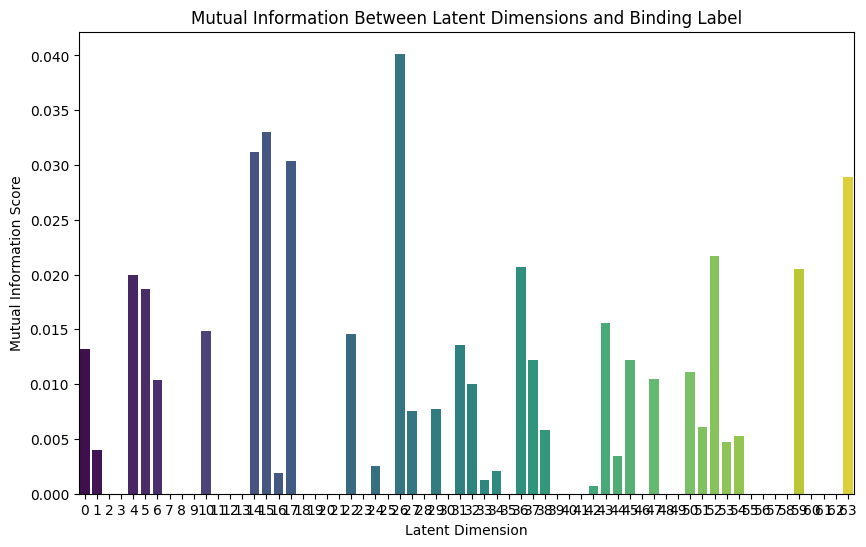

/tmp/ipykernel_423088/2507760955.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=np.arange(len(importances)), y=importances, palette="viridis")


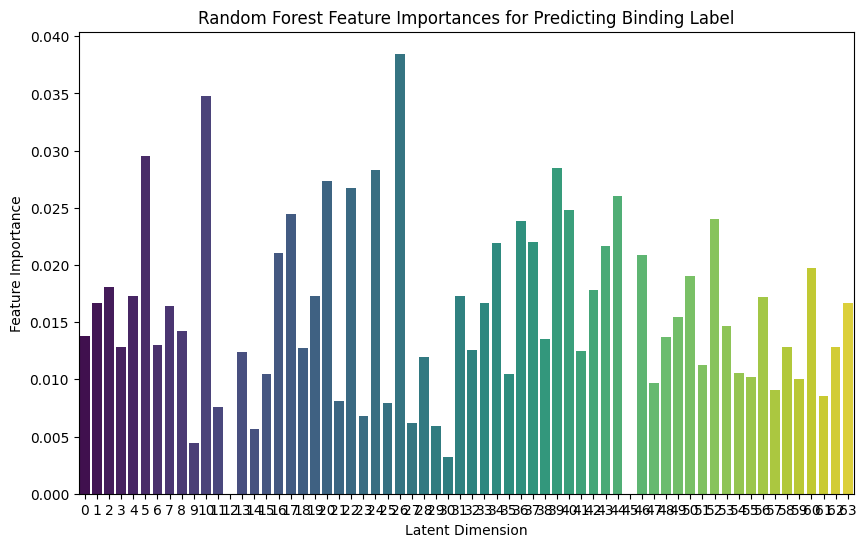

Top 10 latent dimensions by Random Forest feature importance: [26 10  5 39 24 20 22 44 40 17]


In [235]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming:
# - z is your latent representation array of shape [N, latent_dim]
# - train_labels is your binding label array (ensure they are floats)
train_labels = train_data["label"].astype(float).values

# =============================
# 1. Check Variance of Latent Dimensions
# =============================

# Compute variance for each latent dimension
latent_variances = np.var(z, axis=0)

# Plot variance across latent dimensions
plt.figure(figsize=(10,6))
sns.barplot(x=np.arange(len(latent_variances)), y=latent_variances, palette="viridis")
plt.xlabel("Latent Dimension")
plt.ylabel("Variance")
plt.title("Variance of Each Latent Dimension")
plt.show()

# Identify near-zero variance dimensions using a threshold (e.g., 1e-5)
zero_threshold = 1e-5
num_near_zero = np.sum(latent_variances < zero_threshold)
print("Number of near-zero variance latent dimensions:", num_near_zero)


# =============================
# 2. Non‑linear Analysis: Mutual Information
# =============================
from sklearn.feature_selection import mutual_info_regression

# Compute mutual information scores between each latent dimension and the binding label
mi_scores = mutual_info_regression(z, train_labels)

# Plot the mutual information scores
plt.figure(figsize=(10,6))
sns.barplot(x=np.arange(len(mi_scores)), y=mi_scores, palette="viridis")
plt.xlabel("Latent Dimension")
plt.ylabel("Mutual Information Score")
plt.title("Mutual Information Between Latent Dimensions and Binding Label")
plt.show()


# =============================
# 3. Non‑linear Analysis: Downstream Random Forest Model
# =============================
from sklearn.ensemble import RandomForestRegressor

# Train a RandomForestRegressor to predict the binding label from latent features
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(z, train_labels)

# Extract feature importances from the trained model
importances = rf_model.feature_importances_

# Plot the feature importances
plt.figure(figsize=(10,6))
sns.barplot(x=np.arange(len(importances)), y=importances, palette="viridis")
plt.xlabel("Latent Dimension")
plt.ylabel("Feature Importance")
plt.title("Random Forest Feature Importances for Predicting Binding Label")
plt.show()

# Optionally, print the top 10 most important latent dimensions
top_features = np.argsort(importances)[::-1][:10]
print("Top 10 latent dimensions by Random Forest feature importance:", top_features)
